In [111]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px


base_path = os.getcwd()
proj_path = os.path.join(base_path, "Project_2") #/ECE219/Project_2
print(f"base_path: {base_path}")
print(f"proj_path: {proj_path}")

sys.path.append(proj_path)
from pokedex_helper import *

csv_path = os.path.join(proj_path, "Pokemon.csv")
image_dir = os.path.join(proj_path, "images")

base_path: /Users/richardlee/Desktop/UCLA/Classes/2025_Winter/ECE219/ECE219
proj_path: /Users/richardlee/Desktop/UCLA/Classes/2025_Winter/ECE219/ECE219/Project_2


In [116]:
def get_top_pokemon_from_queries(pokedex:pd.DataFrame, queries:list, model, preprocess, device, top_n:int =5):
    query_embeddings = clip_inference_text(model, preprocess, queries, device)
    image_embeddings = clip_inference_image(model, preprocess, pokedex["image_path"], device)

    similarity = compute_similarity_text_to_image(image_embeddings, query_embeddings)
    top_n_pokemon_ids = {}
    for i, query in enumerate(queries):
        top_indices = np.argsort(similarity[:,i])[-top_n:][::-1]
        top_ids = pokedex.iloc[top_indices]["ID"].values
        top_n_pokemon_ids[query] = top_ids
    return top_n_pokemon_ids

def plot_top_pokemon(pokedex, top_pokemon_ids):
    """Plots the top 5 Pokémon for each query."""
    for query, pokemon_ids in top_pokemon_ids.items():
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        fig.suptitle(query, fontsize=14)

        for i, pokemon_id in enumerate(pokemon_ids):
            row = pokedex[pokedex["ID"]==pokemon_id]
            image = Image.open(row["image_path"].values[0])
            axes[i].imshow(image)
            axes[i].axis("off")
            axes[i].set_title(f"{row['Name'].values[0]}\n({row['Type1'].values[0]}, {row['Type2'].values[0]})")
        plt.show()

def umap_projection(pokedex, type_filter, model, preprocess, device, n_neighbors=15, min_dist=0.1, metric='cosine'):
    filtered_pokedex = pokedex[(pokedex["Type1"].isin(type_filter)) | (pokedex["Type1"].isin(type_filter))]
    
    image_embeddings = clip_inference_image(model, preprocess, filtered_pokedex["image_path"], device)
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))

    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    
    distance_matrix = 1 - distance_matrix  # Convert to a distance metric

    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    tsne_df = pd.DataFrame(visualization_data, columns=["x", "y"])
    tsne_df["Pokemon"] = filtered_pokedex["Name"].values
    tsne_df["Type1"] = filtered_pokedex["Type1"].values
    tsne_df["Type2"] = filtered_pokedex["Type2"].values

    # Create a new column to display both types
    tsne_df["Types"] = tsne_df.apply(
        lambda row: f"{row['Type1']} / {row['Type2']}" if pd.notna(row['Type2']) else row['Type1'], axis=1
    )

    # Plot t-SNE clusters
    fig = px.scatter(
        tsne_df, x="x", y="y", color="Type1", hover_name="Pokemon", hover_data=["Types"],
        title=f"t-SNE Clustering of {', '.join(type_filter)} Pokemon"
    )
    fig.show()


def visualize_tsne(pokedex, type_filter, model, preprocess, device):
    """Visualizes Pokémon embeddings using t-SNE."""
    filtered_pokedex = pokedex[(pokedex["Type1"].isin(type_filter)) | (pokedex["Type1"].isin(type_filter))]
    
    image_embeddings = clip_inference_image(model, preprocess, filtered_pokedex["image_path"], device)

    # Apply t-SNE
    tsne_results = TSNE(n_components=2, random_state=42).fit_transform(image_embeddings)
    tsne_df = pd.DataFrame(tsne_results, columns=["x", "y"])
    tsne_df["Pokemon"] = filtered_pokedex["Name"].values
    tsne_df["Type1"] = filtered_pokedex["Type1"].values
    tsne_df["Type2"] = filtered_pokedex["Type2"].values

    # Create a new column to display both types
    tsne_df["Types"] = tsne_df.apply(
        lambda row: f"{row['Type1']} / {row['Type2']}" if pd.notna(row['Type2']) else row['Type1'], axis=1
    )

    # Plot t-SNE clusters
    fig = px.scatter(
        tsne_df, x="x", y="y", color="Type1", hover_name="Pokemon", hover_data=["Types"],
        title=f"t-SNE Clustering of {', '.join(type_filter)} Pokemon"
    )
    fig.show()

100%|██████████| 754/754 [00:32<00:00, 23.16it/s]


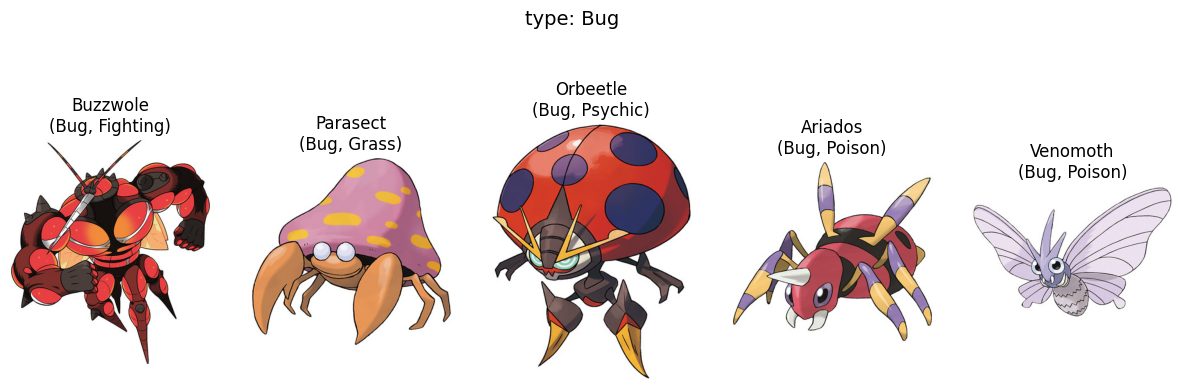

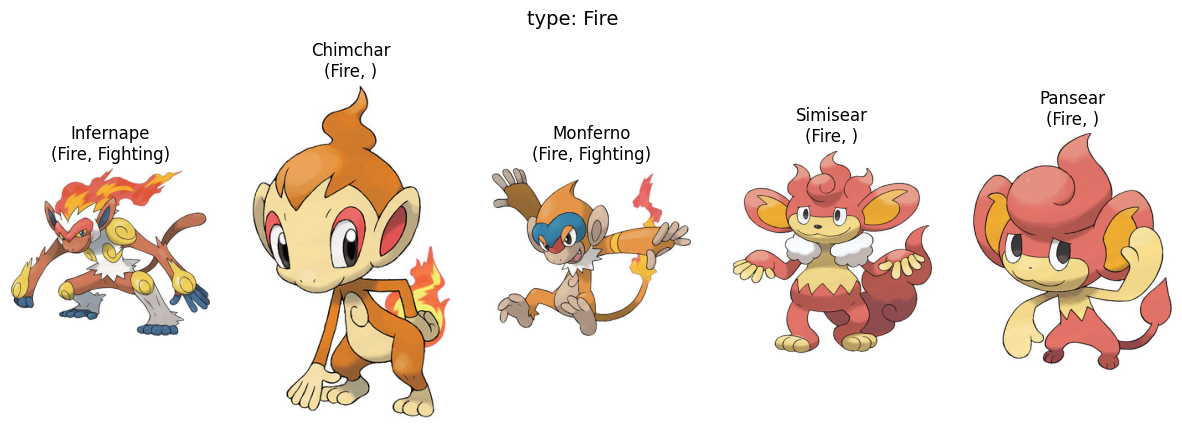

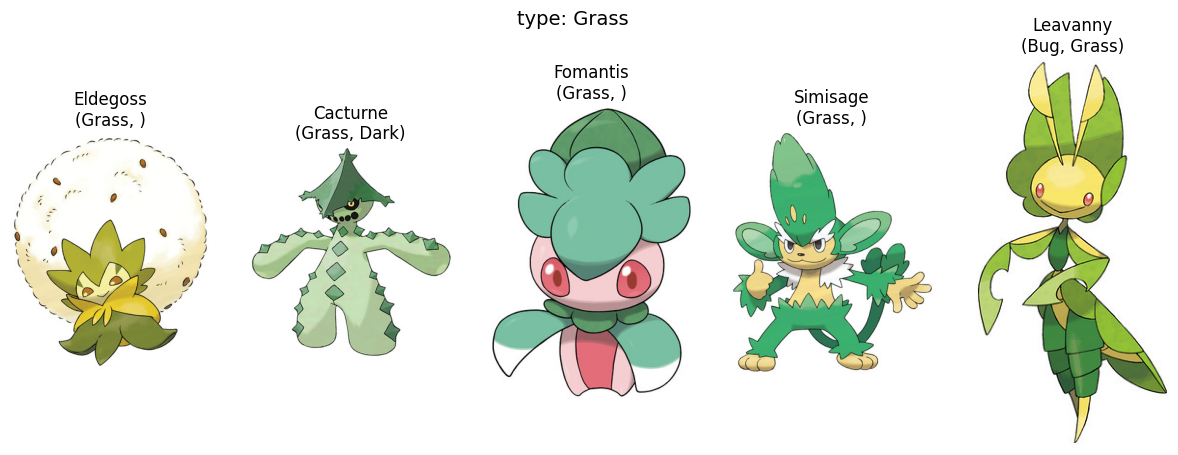

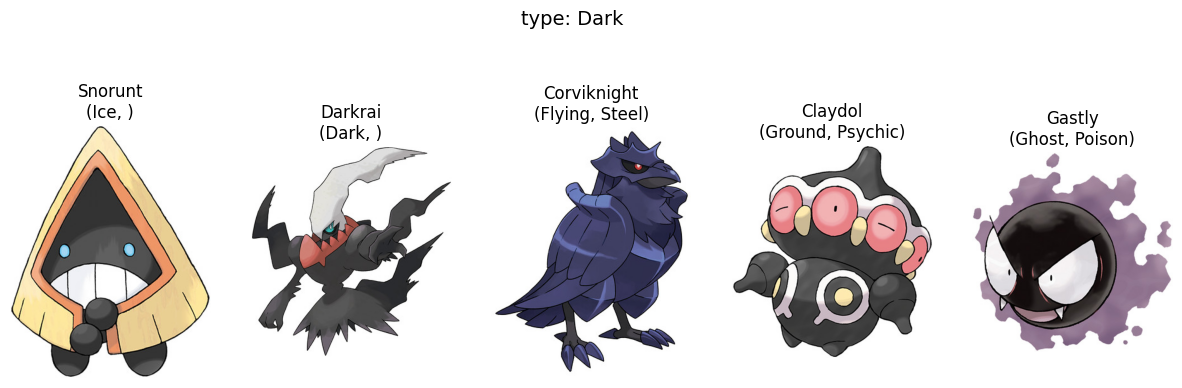

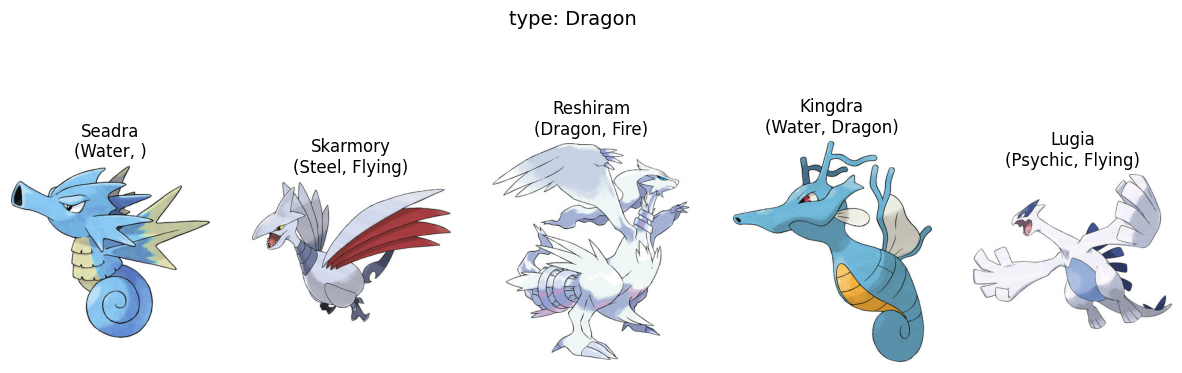

In [94]:
# Load Pokedex
pokedex = construct_pokedex(csv_path, image_dir)

# Load CLIP
model, preprocess, device = load_clip_model()

# Create Queries
queries = [
    "Bug type pokemon", "fire type pokemon", "grass type pokemon", "dark type pokemon", "dragon type pokemon"
]

queries2 = [
    "type: Bug", "type: Fire", "type: Grass",
    "type: Dark", "type: Dragon"
]

top_5_pokemon_ids = get_top_pokemon_from_queries(pokedex, queries2, model, preprocess, device, top_n=5)
plot_top_pokemon(pokedex, top_5_pokemon_ids)

In [117]:
visualize_tsne(pokedex, ["Bug", "Fire", "Grass"], model, preprocess, device)
umap_projection(pokedex, ["Bug", "Fire", "Grass"], model, preprocess, device)

100%|██████████| 192/192 [00:08<00:00, 23.45it/s]


100%|██████████| 192/192 [00:08<00:00, 23.60it/s]
